In [1]:
import numpy as np
import uproot
import pandas as pd
import matplotlib.pyplot as plt
import HomeMade as hm
import xgboost as xgb
from sklearn.metrics import roc_curve, roc_auc_score

In [304]:
N = 1e5

all_features = "v0_ks_mass v0_ks_massErr pv0_x pv0_y pv0_z a0xy a0 a0z cosTheta v0_chi2 \
v0_x v0_y v0_z v0_rxy v0_rxyErr v0_px v0_py v0_pz v0_pt v0_p \
v0_ptErr \
v0_px1 v0_py1 v0_pz1 v0_pt1 \
v0_p1 v0_px2 v0_py2 v0_pz2 v0_pt2 v0_p2 v0_phi1 v0_theta1 \
v0_qOverP1 v0_phi2 v0_theta2 v0_qOverP2 alpha calpha epsilon1 \
epsilon2 Alpha pL1 pL2 pT thetastar rapidity_ks pseudorapidity".split(" ")

path = "data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
file = uproot.open(path)
data = file['tree'].pandas.df(all_features, entrystop = N)

# path = "data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
# file = uproot.open(path)
# mc = file['tree'].pandas.df(all_features + ['trueKs'], entrystop = N)

data = data.loc[(data.v0_ks_mass > 400) & (data.v0_ks_mass < 600)]

In [308]:
f1 = "v0_pz1 v0_pz v0_pz2 pseudorapidity rapidity_ks v0_theta1 v0_theta2".split(" ")
f2 = "v0_phi1 v0_py1 v0_py v0_py2 v0_phi2".split(" ")# pT".split(" ")
f3 = "v0_px2 v0_px v0_px1".split(" ")
f4 = "v0_rxyErr v0_rxy a0 a0xy".split(" ")
f5 = "v0_ptErr v0_p1 pL1 v0_pt1 v0_pt v0_p v0_qOverP1 calpha epsilon2 Alpha alpha thetastar".split(" ") \
+data.columns[np.logical_not(data.columns.isin(np.array(fs).sum()))].to_list()
fs = [f1,f2,f3,f4,f5]

In [327]:
f5

['v0_ptErr',
 'v0_p1',
 'pL1',
 'v0_pt1',
 'v0_pt',
 'v0_p',
 'v0_qOverP1',
 'calpha',
 'epsilon2',
 'Alpha',
 'alpha',
 'thetastar',
 'v0_ks_mass',
 'v0_ks_massErr',
 'pv0_x',
 'pv0_y',
 'pv0_z',
 'a0z',
 'cosTheta',
 'v0_chi2',
 'v0_x',
 'v0_y',
 'v0_z',
 'v0_pt2',
 'v0_p2',
 'v0_qOverP2',
 'epsilon1',
 'pL2',
 'pT']

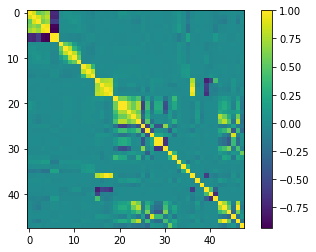

In [309]:
plt.imshow(data[np.array(fs).sum()].corr())
plt.colorbar()

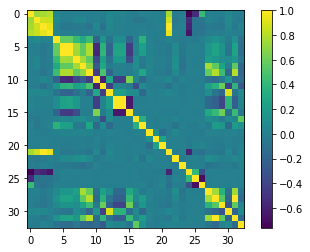

In [310]:
plt.imshow(data[f4+f5].corr())
plt.colorbar()

In [311]:
def R_mat(I, indeces):
    def R(theta):
        tmp = I.copy()
        tmp[indeces] = np.cos(theta), -np.sin(theta), np.sin(theta), np.cos(theta)
        return tmp
    return R

def gen_rot_matrices(dims):
    rotations = []
    I = np.identity(dims)
    for row in range(dims):
        for col in range(dims)[row+1:]:
            rotations.append(R_mat(I,([row,row,col,col],[row,col,row,col])))
    return rotations

In [312]:
rots = gen_rot_matrices(4)

In [313]:
from scipy.optimize import minimize

In [314]:
dims = 4
def fun(x):
    rotation = np.identity(dims)
    for i, rot in enumerate(rots):
        rotation = rotation@rot(x[i])
        
    return pd.concat([data[f4]@rotation,data[f5]],axis=1).corr().iloc[:dims,dims:].abs().sum().sum()

In [315]:
M = minimize(fun,
            x0 = np.zeros(len(rots)))

In [316]:
rotation = np.identity(dims)
for i, rot in enumerate(rots):
    rotation = rotation@rot(M.x[i])

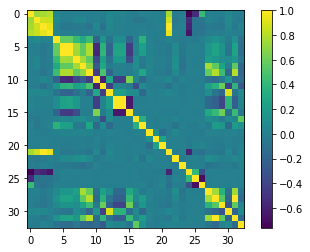

In [334]:
plt.imshow(data[f4+f5].corr())
plt.colorbar()

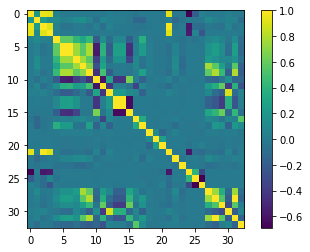

In [317]:
plt.imshow(pd.concat([data[f4]@rotation,data[f5]],axis=1).corr())
plt.colorbar()

In [337]:
M.x

array([ 0.38097996, -0.11708956,  0.65654576, -0.52356683, -0.40087969,
       -0.04715918])

In [335]:
fun(M.x)

8.220302927963454

In [336]:
fun(np.zeros(len(rots)))

9.658601103785251

In [321]:
corr_rot = pd.concat([data[f4]@rotation,data[f5]],axis=1).corr().iloc[:dims,dims:]

In [322]:
corr = data[f4+f5].corr().iloc[:dims,dims:]

In [323]:
resi = corr.to_numpy() - corr_rot.to_numpy()

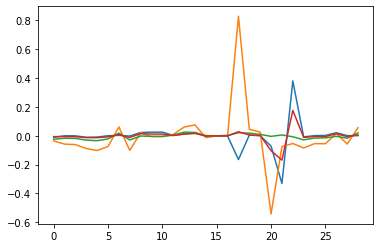

In [324]:
fig, ax = plt.subplots()
for res in resi:
    ax.plot(res)

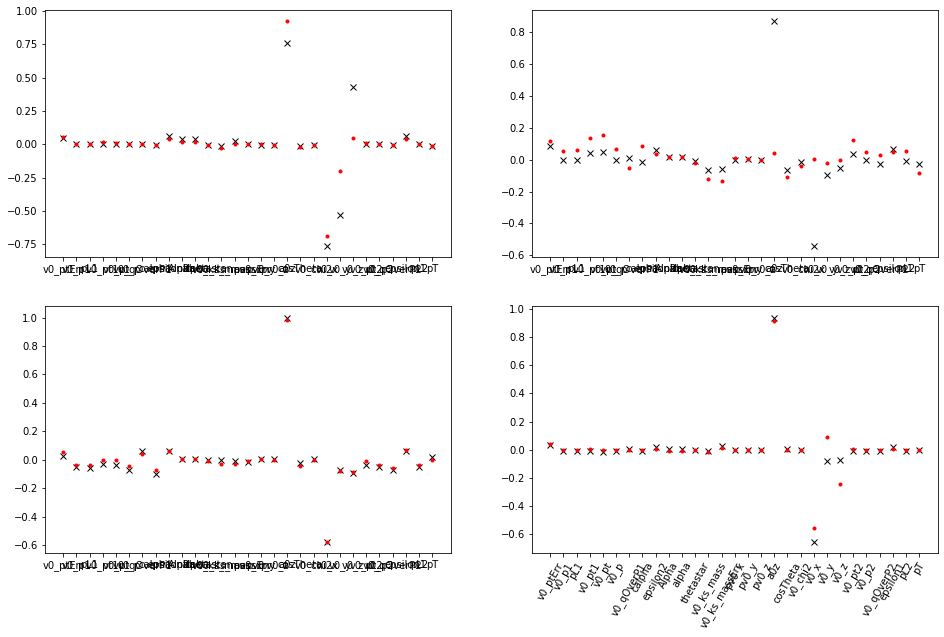

In [333]:
fig, ax = plt.subplots(figsize=(16,10),ncols=2,nrows=2)
ax = ax.flatten()
for i in range(4):
    ax[i].plot(corr.iloc[i],'kx')
    ax[i].plot(corr_rot.iloc[i],'r.')
    plt.xticks(rotation=60)

In [ ]:
corr.

Linear fit:
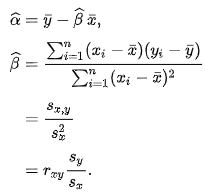

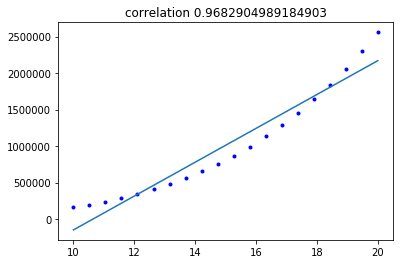

In [75]:
x = np.linspace(10,20,20)
y = np.linspace(20,40,20)**4

c = np.cov(x,y)
b = c[0,1]/c[0,0]
a = y.mean() - b*x.mean()

plt.plot(x,y,'b.')
p = np.corrcoef(x,y)[0,1]
p1 = np.cov(x,y)[0,1]
plt.title(f'correlation {p}')
plt.plot(x,b*x + a)

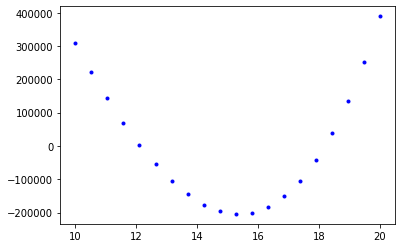

In [74]:
plt.plot(x,y -(a + b*x),'b.')